# Model

W procesie modelowania tworzymy dwa modele, bazowy i docelowy.

## Wczytanie danych

In [108]:
#installs pandasql within jupyter kernel
%pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [109]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import time
import pandas as pd
from pandasql import sqldf
import csv

In [110]:
dataPath = "IUM21L_Zad_03_02_v2"
citiesPath = "cities.csv"

In [111]:
deliveriesFile = open(dataPath + "/deliveries.jsonl", "r")
productsFile = open(dataPath + "/products.jsonl", "r")
sessionsFile = open(dataPath + "/sessions.jsonl", "r")
usersFile = open(dataPath + "/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

deliveriesDF = pd.DataFrame.from_dict(deliveries)
productsDF = pd.DataFrame.from_dict(products)
sessionsDF = pd.DataFrame.from_dict(sessions)
usersDF = pd.DataFrame.from_dict(users)

pysqldf = lambda q: sqldf(q, globals())
dataDF = pysqldf("SELECT * FROM sessionsDF s JOIN deliveriesDF d ON s.purchase_id = d.purchase_id JOIN productsDF p ON s.product_id = p.product_id JOIN usersDF u ON s.user_id = u.user_id;")
projectedDataDF = pysqldf("SELECT purchase_timestamp, delivery_timestamp, delivery_company, offered_discount, product_name, price, category_path, name, city, street FROM dataDF;")

In [112]:
pysqldf("SELECT * FROM projectedDataDF LIMIT 5;")

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street
0,2021-04-01T15:52:47,2021-04-02T14:06:34.432964,620,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
1,2021-04-01T02:26:23,2021-04-02T10:45:27.707128,360,15,Philips SDV5225,129.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
2,2021-01-03T05:11:17,2021-01-04T15:43:07.635371,620,0,Kinect Joy Ride (Xbox 360),69.00,Gry i konsole;Gry na konsole;Gry Xbox 360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
3,2021-02-17T12:59:54,2021-02-18T11:52:42.608746,620,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53
4,2021-02-13T09:17:52,2021-02-15T08:59:28.973167,620,5,Doom 3 (PC),19.99,Gry i konsole;Gry komputerowe,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53


## Przygotowanie danych

### Funkcje i struktury pomocnicze

In [113]:
# Convert date to unix timestamp (seconds only)
def dateToTimestamp(date):
    date = date.split('.')[0]
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()
    return time.mktime(date)

def timestampToDate(timestamp):
    return datetime.fromtimestamp(timestamp).strftime("%Y-%m-%dT%H:%M:%S")



N_SECONDS = 3600.0

extendedDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE purchase_timestamp < delivery_timestamp")

#create columns
extendedDataDF["purchase_timestamp_sec"] = 0
extendedDataDF["delivery_timestamp_sec"] = 0
extendedDataDF["delivery_time_h"] = 0.0
extendedDataDF["purchase_day_name"] = ""

for index, _ in extendedDataDF.iterrows():
    extendedDataDF.at[index, "purchase_timestamp_sec"] = dateToTimestamp(extendedDataDF["purchase_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_timestamp_sec"] = dateToTimestamp(extendedDataDF["delivery_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_time_h"] = float(extendedDataDF["delivery_timestamp_sec"].iloc[index] - extendedDataDF["purchase_timestamp_sec"].iloc[index]) / N_SECONDS
    extendedDataDF.at[index, "purchase_timestamp"] = pd.to_datetime(extendedDataDF["purchase_timestamp"].iloc[index])
    extendedDataDF.at[index, "delivery_timestamp"] = pd.to_datetime(extendedDataDF["delivery_timestamp"].iloc[index])
    extendedDataDF.at[index, "purchase_day_name"] = extendedDataDF["purchase_timestamp"].iloc[index].day_name()

extendedDataDF

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street,purchase_timestamp_sec,delivery_timestamp_sec,delivery_time_h,purchase_day_name
0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1617285167,1617365194,22.229722,Thursday
1,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,15,Philips SDV5225,129.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1617236783,1617353127,32.317778,Thursday
2,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,0,Kinect Joy Ride (Xbox 360),69.00,Gry i konsole;Gry na konsole;Gry Xbox 360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1609647077,1609771387,34.530556,Sunday
3,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1613563194,1613645562,22.880000,Wednesday
4,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,5,Doom 3 (PC),19.99,Gry i konsole;Gry komputerowe,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1613204272,1613375968,47.693333,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,2021-04-15 13:00:45,2021-04-16 08:00:40.223545,516,5,Manta DVD064,109.00,Sprzęt RTV;Video;Odtwarzacze DVD,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1618484445,1618552840,18.998611,Thursday
7283,2021-01-28 09:32:38,2021-01-29 14:26:03.596544,360,20,Kyocera FS-3540MFP,5126.00,Komputery;Drukarki i skanery;Biurowe urządzeni...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1611822758,1611926763,28.890278,Thursday
7284,2021-03-22 20:30:58,2021-03-24 08:26:34.660190,620,10,Szalone Króliki Na żywo i w kolorze (Xbox 360),49.99,Gry i konsole;Gry na konsole;Gry Xbox 360,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1616441458,1616570794,35.926667,Monday
7285,2021-02-19 03:55:11,2021-02-20 18:26:44.646625,620,15,HTC HS-S200,14.99,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1613703311,1613842004,38.525833,Friday


### Miasta

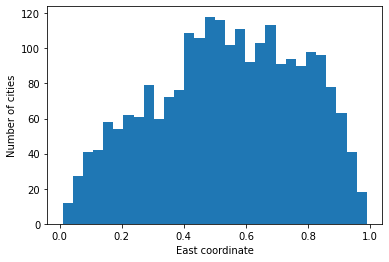

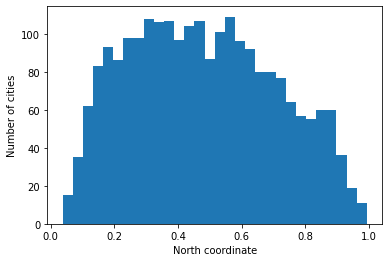

In [114]:
# Convert cities to coordinates, and then normalize the coordinates based on min and max values for Poland

# Read cities coordinates from csv file
# Strip cities names of whitespaces and convert coordinates to floats [degrees] by dividing minutes by 60
# City data contains few cities outside Poland, so we skip them using the following bounds
minEastCoord = 14.11
maxEastCoord = 24.15
minNorthCoord = 49
maxNorthCoord = 54.84

cityDatabaseNames = []
cityDatabaseCoords = []
with open(citiesPath, newline='') as csvfile:
    citiesReader = csv.reader(csvfile)
    for row in citiesReader:
        coordRow = []
        for cell in row:
            cell = cell.strip()
            if len(cell) > 1:
                if cell[-1] == 'E' or cell[-1] == 'N':
                    numericCoord = float(cell[0:2]) + float(cell[3:5])/60
                    coordRow.append(numericCoord)
                else:
                    cityDatabaseNames.append(cell)
        if coordRow[0] >= minEastCoord and \
           coordRow[0] <= maxEastCoord and \
           coordRow[1] >= minNorthCoord and \
           coordRow[1] <= maxNorthCoord:
            cityDatabaseCoords.append(coordRow)
        else:
            del cityDatabaseNames[-1]
            
        
#Convert to numpy
citiesCoordinatesDataArray = np.array(cityDatabaseCoords)

citiesCoordinatesDataArray[:, 0] = (citiesCoordinatesDataArray[:, 0]-minEastCoord)/(maxEastCoord-minEastCoord)
citiesCoordinatesDataArray[:, 1] = (citiesCoordinatesDataArray[:, 1]-minNorthCoord)/(maxNorthCoord-minNorthCoord)
    
plt.hist(citiesCoordinatesDataArray[:,0], bins=30, density=False)
plt.xlabel("East coordinate")
plt.ylabel("Number of cities")
plt.show()

plt.hist(citiesCoordinatesDataArray[:,1], bins=30, density=False)
plt.xlabel("North coordinate")
plt.ylabel("Number of cities")
plt.show()

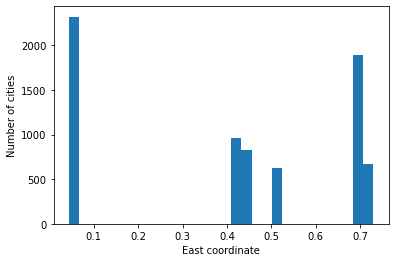

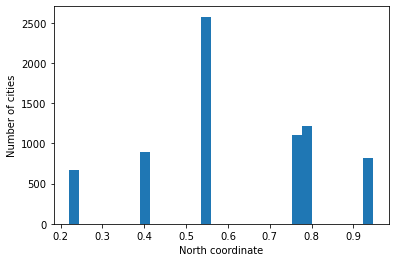

(7287, 2)


In [115]:
# Get city attribute
citiesNames = pysqldf("SELECT City FROM projectedDataDF;").to_numpy()

cityCoordAttribute = np.empty(shape=(citiesNames.size, 2))
for i in range(len(citiesNames)):
    index = cityDatabaseNames.index(citiesNames[i])
    cityCoordAttribute[i] = citiesCoordinatesDataArray[index]
    
plt.hist(cityCoordAttribute[:,0], bins=30, density=False)
plt.xlabel("East coordinate")
plt.ylabel("Number of cities")
plt.show()

plt.hist(cityCoordAttribute[:,1], bins=30, density=False)
plt.xlabel("North coordinate")
plt.ylabel("Number of cities")
plt.show()

print(cityCoordAttribute.shape)

### Firma kurierska

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]]


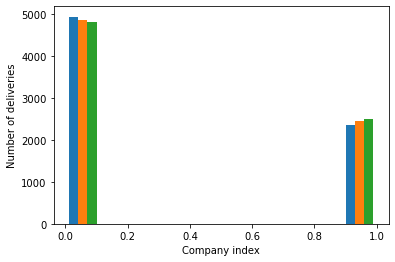

(7287, 3)


In [116]:
companiesNames = pysqldf("SELECT delivery_company FROM projectedDataDF;").to_numpy()
distinctCompaniesNames = np.unique(companiesNames)
companyAttribute = np.zeros(shape=(len(companiesNames), len(distinctCompaniesNames)))

for i in range(len(companiesNames)):
    companyAttribute[i, np.where(companiesNames[i] == distinctCompaniesNames)[0]] = 1

print(companyAttribute)
plt.hist(companyAttribute, bins=9, density=False)
plt.xlabel("Company index")
plt.ylabel("Number of deliveries")
plt.show()

print(companyAttribute.shape)

### Dzień tygodnia i pora dnia zakupu

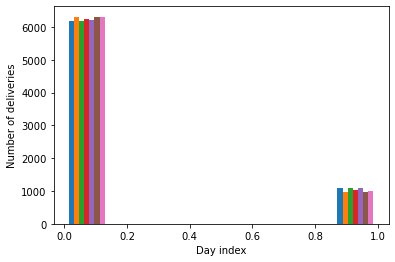

(7287, 7)


In [117]:
dayNames = pysqldf("SELECT purchase_day_name FROM extendedDataDF;").to_numpy()
distinctDayNames = np.unique(dayNames)
dayAttribute = np.zeros(shape=(len(dayNames), len(distinctDayNames)))

for i in range(len(dayNames)):
    dayAttribute[i, np.where(dayNames[i] == distinctDayNames)[0]] = 1

plt.hist(dayAttribute, bins=7, density=False)
plt.xlabel("Day index")
plt.ylabel("Number of deliveries")
plt.show()

print(dayAttribute.shape)

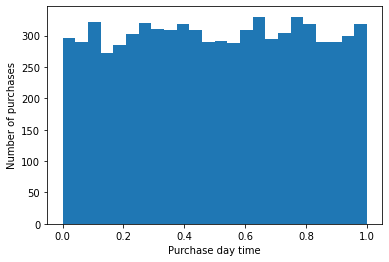

(7287, 1)


In [118]:
purchaseTimes = pysqldf("SELECT purchase_timestamp FROM extendedDataDF;").to_numpy()

datetimes = [datetime.strptime(t, '%Y-%m-%d %H:%M:%S.%f') for t in purchaseTimes[:,0]]
purchaseTimeAttribute = np.asarray([t.hour*3600 + t.minute*60 + t.second for t in datetimes], dtype=np.float32)
purchaseTimeAttribute /= 3600*24

plt.hist(purchaseTimeAttribute, bins=24, density=False)
plt.xlabel("Purchase day time")
plt.ylabel("Number of purchases")
plt.show()

purchaseTimeAttribute = np.reshape(purchaseTimeAttribute, (-1, 1))
print(purchaseTimeAttribute.shape)

### Czas dostawy

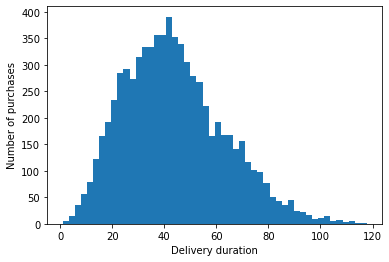

(7287, 1)


In [119]:
deliveryTimes = pysqldf("SELECT delivery_time_h FROM extendedDataDF;").to_numpy()

plt.hist(deliveryTimes, bins=50, density=False)
plt.xlabel("Delivery duration")
plt.ylabel("Number of purchases")
plt.show()

print(deliveryTimes.shape)

## Podział na zbiory treningowy i testowy

In [120]:
trainingPart = 0.8

fullData = np.concatenate((cityCoordAttribute, \
                           companyAttribute, \
                           dayAttribute, \
                           purchaseTimeAttribute, \
                           deliveryTimes), axis=1)

np.random.seed(2)
np.random.shuffle(fullData)
trainSize = int(trainingPart*len(fullData))
trainData, testData = fullData[:trainSize,:-1], fullData[trainSize:,:-1]
trainLabels, testLabels = fullData[:trainSize,-1:], fullData[trainSize:,-1:]
print(trainData.shape)
print(trainLabels.shape)
print(testData.shape)
print(testLabels.shape)

(5829, 13)
(5829, 1)
(1458, 13)
(1458, 1)


# Predykcja średniego czasu dostawy

Po pierwsze RMSE dla predykcji stałej średniej długości czasu dostawy:

In [121]:
avgDuration = np.average(testLabels)
print(np.sqrt(np.mean((avgDuration-testLabels)**2)))

18.484341420090114


# Prosty model regresji liniowej

In [122]:
from sklearn import linear_model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
import pickle

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def predict_from_file(filename, data, isKeras):
    if isKeras:
        model = keras.models.load_model(filename, compile=False)
    else:
        model = pickle.load(open(filename, 'rb'))
    return model.predict(data)

In [123]:
regr = linear_model.LinearRegression()
regr.fit(trainData, trainLabels)

filename = 'base_model.pkl'
pickle.dump(regr, open(filename, 'wb'))

In [124]:
#for i in range(len(predictions)):
#    deliveryTime = (testData[i, 4]*24 + predictions[i]) % 24
#    if deliveryTime > 18:
#        predictions[i] -= deliveryTime-18
#    if deliveryTime < 2:
#        predictions[i] -= deliveryTime+6
#    else:
#        if deliveryTime < 8:
#            predictions[i] += 8-deliveryTime
print(tf.get_static_value(root_mean_squared_error(predict_from_file('base_model.pkl', testData, False), testLabels)))

16.026476245279582


# Model docelowy

In [125]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 50])
    plt.xlabel('Epoch')
    plt.ylabel('Error [RMSE]')
    plt.legend()
    plt.grid(True)


    
def test_model(model):
    model.compile(loss=root_mean_squared_error,
              optimizer=tf.keras.optimizers.Adam(0.001))
    model.summary()

    return model.fit(trainData, trainLabels, validation_split=0.2, epochs=24)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1024)              14336     
_________________________________________________________________
dropout_10 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

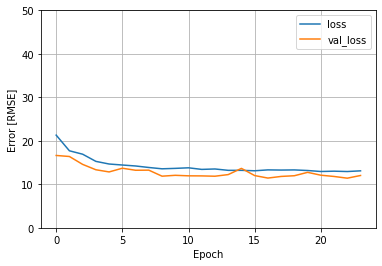

In [126]:
model = keras.Sequential()
model.add(keras.Input(shape=(trainData.shape[1],)))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1))

plot_loss(test_model(model))

model.save('full_model')

In [127]:
print(tf.get_static_value(root_mean_squared_error(predict_from_file('full_model', testData, True), testLabels)))

11.58896207728954
